# Credit Score classification

In [18]:
import pandas as pd
import numpy as np

In [19]:
df=pd.read_csv('train.csv')
df.head

<ipython-input-19-7e6aef0b5f1d>:1: DtypeWarning: Columns (26) have mixed types. Specify dtype option on import or set low_memory=False.
  df=pd.read_csv('train.csv')


<bound method NDFrame.head of             ID Customer_ID     Month           Name   Age          SSN  \
0       0x1602   CUS_0xd40   January  Aaron Maashoh    23  821-00-0265   
1       0x1603   CUS_0xd40  February  Aaron Maashoh    23  821-00-0265   
2       0x1604   CUS_0xd40     March  Aaron Maashoh  -500  821-00-0265   
3       0x1605   CUS_0xd40     April  Aaron Maashoh    23  821-00-0265   
4       0x1606   CUS_0xd40       May  Aaron Maashoh    23  821-00-0265   
...        ...         ...       ...            ...   ...          ...   
99995  0x25fe9  CUS_0x942c     April          Nicks    25  078-73-5990   
99996  0x25fea  CUS_0x942c       May          Nicks    25  078-73-5990   
99997  0x25feb  CUS_0x942c      June          Nicks    25  078-73-5990   
99998  0x25fec  CUS_0x942c      July          Nicks    25  078-73-5990   
99999  0x25fed  CUS_0x942c    August          Nicks    25  078-73-5990   

      Occupation Annual_Income  Monthly_Inhand_Salary  Num_Bank_Accounts  ...  \


# Cleaning
After reading the dataset from the csv file, the first step is to clean the dataset so it can be used to train and test machine learning models. The first step is to drop unnecessary columns, there are columns that are guaranteed to have no effect on the model's accuracy and include things like Ids and social security numbers. The month column is ommited because it does not affect the credit score is as well.

The next step in the process is to clear duplicate rows from the dataset, because it can cause models to overfit. After that we clear outliers from the numerical columns in the dataset, since they are not representative of the dataset used. empty rows are filled with the median vlaue of their respecitve column. Outliers are cleared based on a Z score calculation, which gets rid of outliers based on the dataset's standard deviation.

Finally, before visualizing our dataset, the categorical columns are cleared of missing values, and errors. The 'Credit_History_Age' Column is converted to an integer representing the number of months. The 'Type_of_Loan' column is converted into several binary column representing each loan type. This is because an entry can have any number of types from the ones avialbale. Handling it using a binary to show if a loan was taken adapts it to work with machine learning models. After that, classes that are meaningless are removed from the categorical columns that need it. Now the data can be visualized in a meaningful way.

In [20]:
from scipy import stats
#Cleaning
#Drop unnecessary columns: Ids and SSNs
columns_to_drop = ['Customer_ID','ID','SSN', 'Month']
df.drop(columns=columns_to_drop, inplace=True)
#Clear rows with missing data
drop_missing_df = df.dropna()
#Clear duplicates
clear_duplicate_df = drop_missing_df.drop_duplicates()
#Clear name column
drop = ["Name"]
clear_duplicate_df.drop(columns=drop, inplace=True)
#Clear outliers from numerical columns
columns_to_clear = ['Age','Annual_Income','Monthly_Inhand_Salary','Num_Bank_Accounts','Num_Credit_Card','Interest_Rate','Num_of_Loan','Delay_from_due_date','Num_of_Delayed_Payment','Changed_Credit_Limit','Num_Credit_Inquiries','Outstanding_Debt','Credit_Utilization_Ratio','Total_EMI_per_month','Amount_invested_monthly','Monthly_Balance']

outlier_df = clear_duplicate_df.copy()

for column in columns_to_clear:
  outlier_df[column] = pd.to_numeric(outlier_df[column], errors='coerce')
  median_value = outlier_df[column].median()
  outlier_df[column].fillna(median_value, inplace=True)

for column in columns_to_clear:
  z_scores = stats.zscore(outlier_df[column])
  threshold = 3
  outlier_indices = (z_scores > threshold) | (z_scores < -threshold)
  outlier_df = outlier_df[~outlier_indices]

#Cleaning Categorical columns for visiualizing
#Type of loan column
def convert_to_months(s):
    if pd.isna(s):
        return None  # Return None or an appropriate value for missing entries
    parts = s.split(' ')
    years = int(parts[0])
    months = int(parts[3])
    return years * 12 + months

outlier_df['Credit_History_Age_in_Months'] = outlier_df['Credit_History_Age'].apply(convert_to_months)
outlier_df.drop('Credit_History_Age', axis=1, inplace=True)
unique_loan_types = [
    "Personal Loan", "Student Loan", "Credit-Builder Loan",
    "Debt Consolidation Loan", "Payday Loan", "Home Equity Loan",
    "Auto Loan", "Not Specified"
]
for loan_type in unique_loan_types:
    # Create a new column for each loan type, marked as 1 if the loan type is present in the entry, else 0
    outlier_df[f"LoanType_{loan_type.replace(' ', '_')}"] = outlier_df['Type_of_Loan'].apply(lambda x: 1 if loan_type in x else 0)
outlier_df.drop('Type_of_Loan', axis=1, inplace=True)
#remove irrelevant entries from Payment behavior column
outlier_df = outlier_df[outlier_df['Payment_Behaviour'] != '!@9#%8']
#Remove meaningless class from Credit_Mix column
cleaned_df = outlier_df[outlier_df['Credit_Mix'] != '_']
#Remove entries where Credit Mix isnt Yes or No
filtered_df = cleaned_df.loc[outlier_df['Payment_of_Min_Amount'].isin(['Yes', 'No'])]
print(filtered_df)



        Age Occupation  Annual_Income  Monthly_Inhand_Salary  \
6      23.0  Scientist       19114.12            1824.843333   
8      33.0    _______       34847.84            3037.986667   
9      28.0    Teacher       34847.84            3037.986667   
12     28.0    Teacher       34847.84            3037.986667   
13     28.0    Teacher       34847.84            3037.986667   
...     ...        ...            ...                    ...   
99976  49.0     Writer       37188.10            3097.008333   
99977  49.0     Writer       37188.10            3097.008333   
99984  28.0  Architect       20002.88            1929.906667   
99985  28.0  Architect       20002.88            1929.906667   
99991  29.0  Architect       20002.88            1929.906667   

       Num_Bank_Accounts  Num_Credit_Card  Interest_Rate  Num_of_Loan  \
6                      3                4              3          4.0   
8                      2                4              6          1.0   
9           

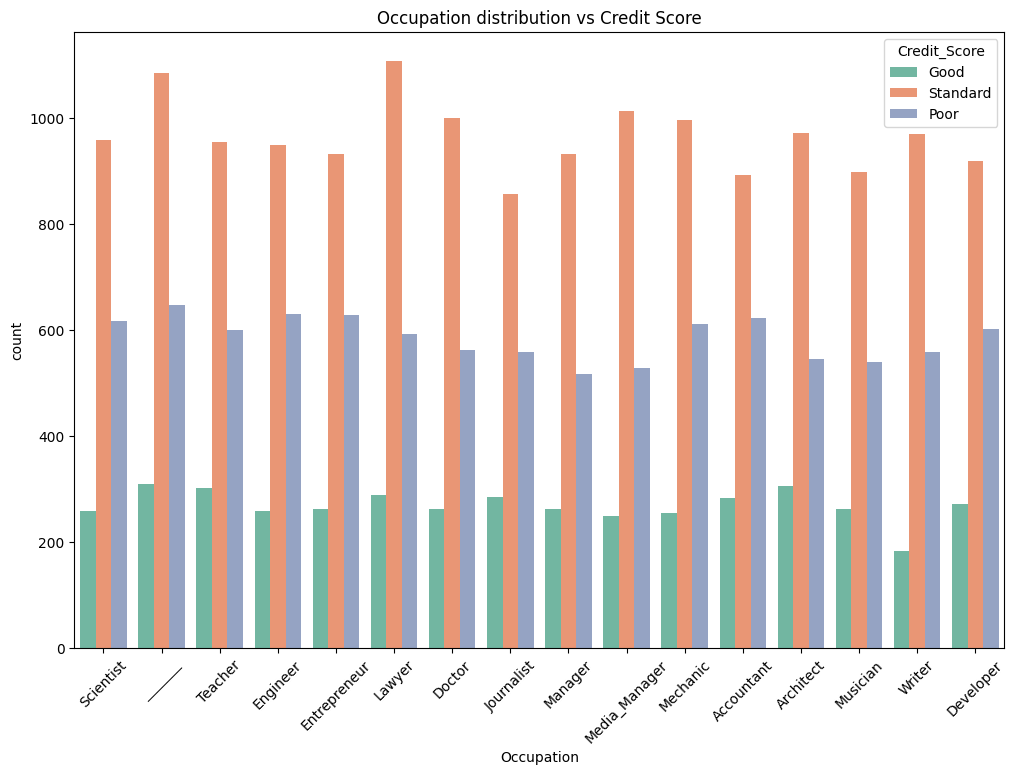

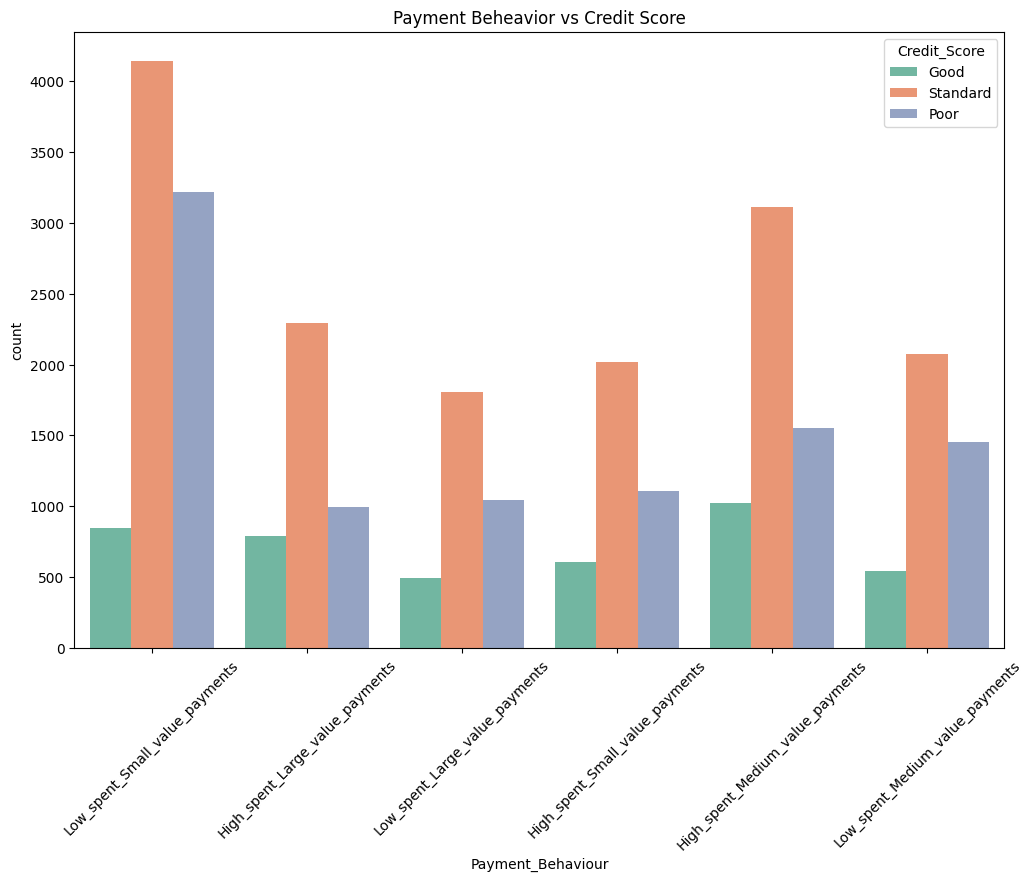

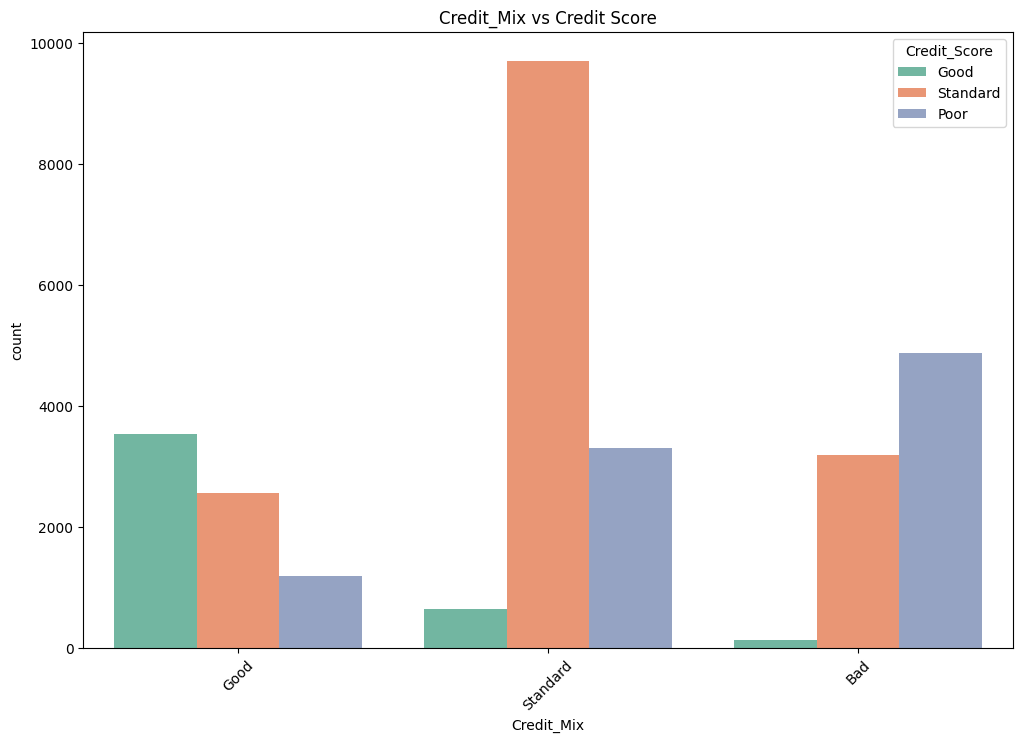

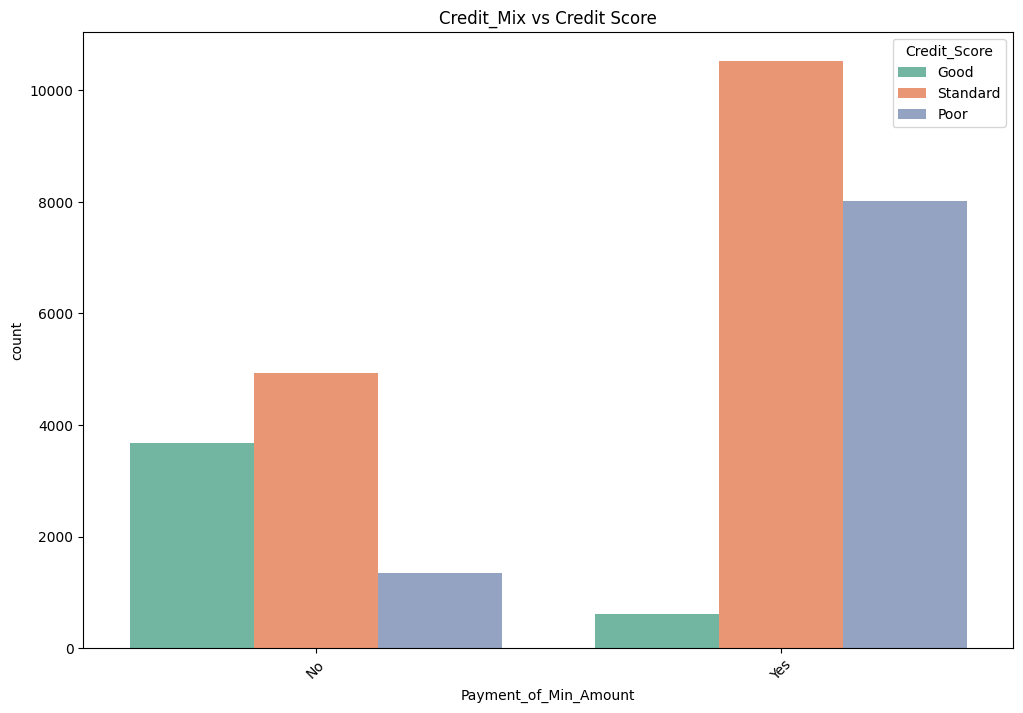

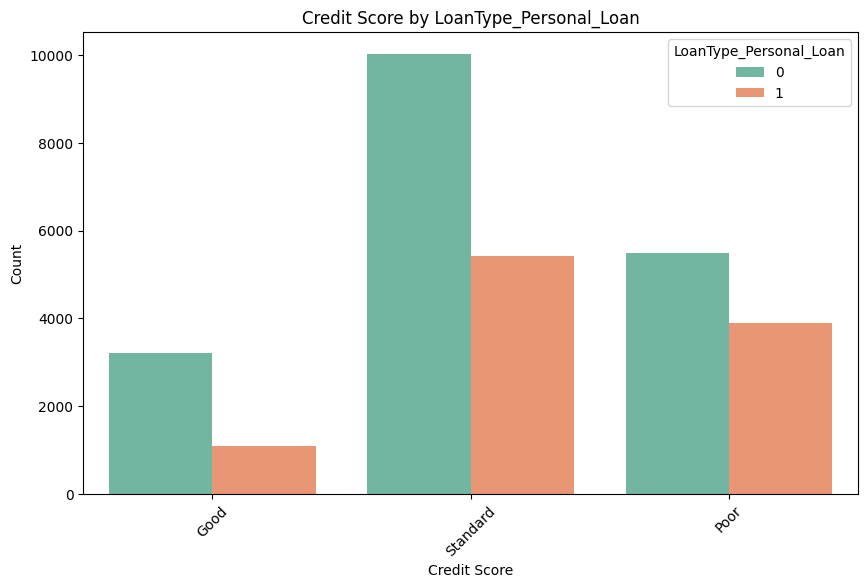

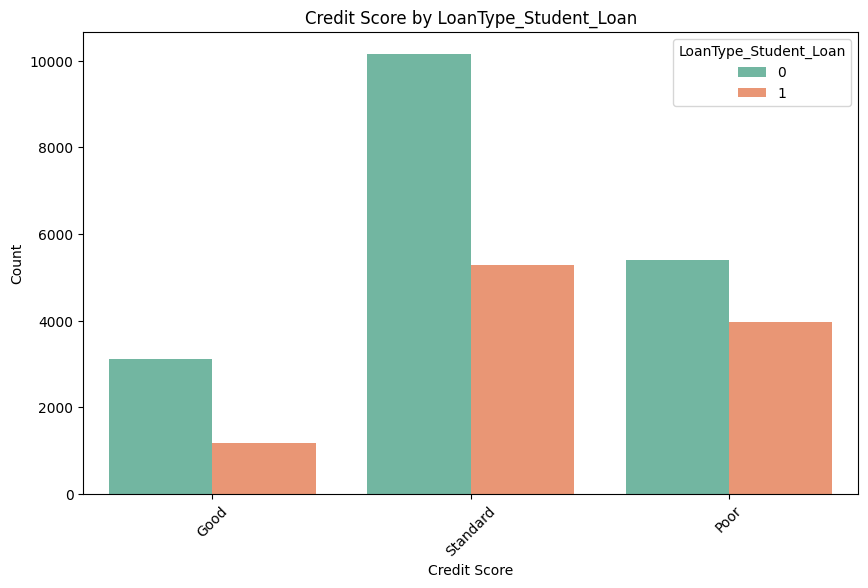

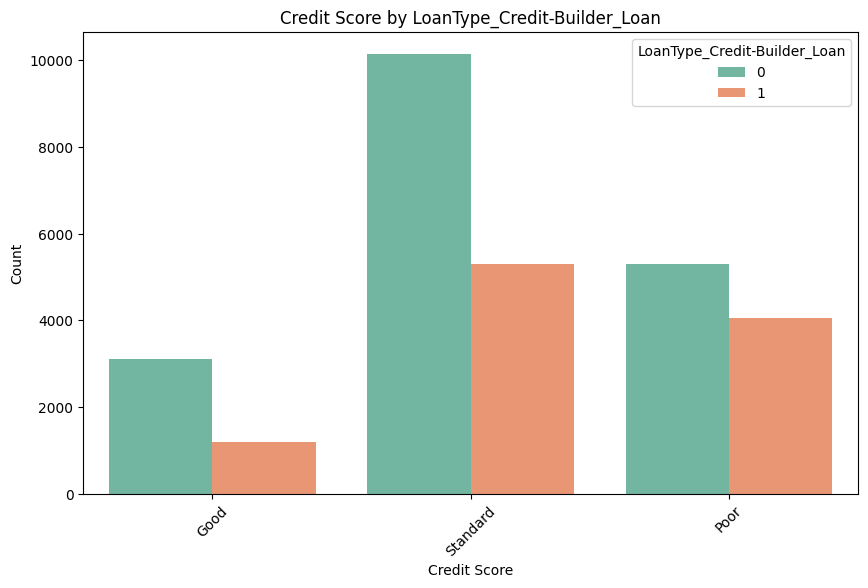

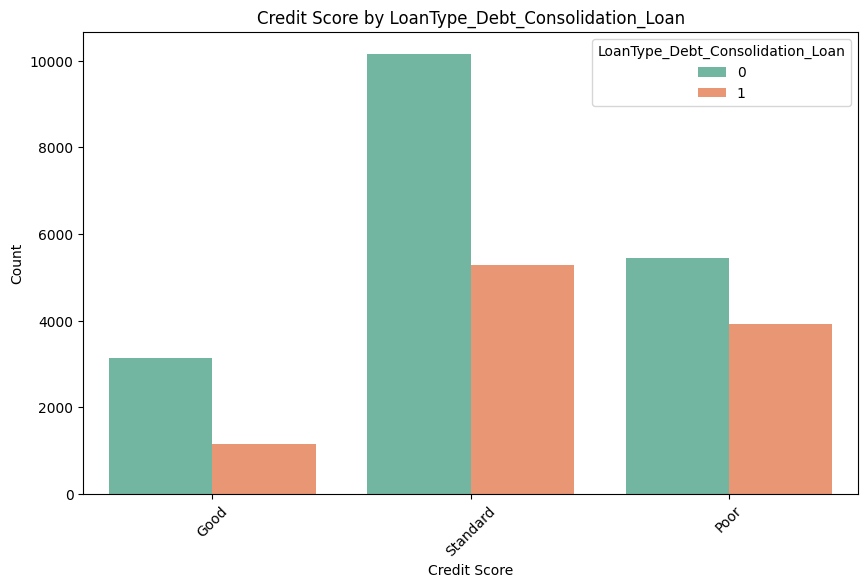

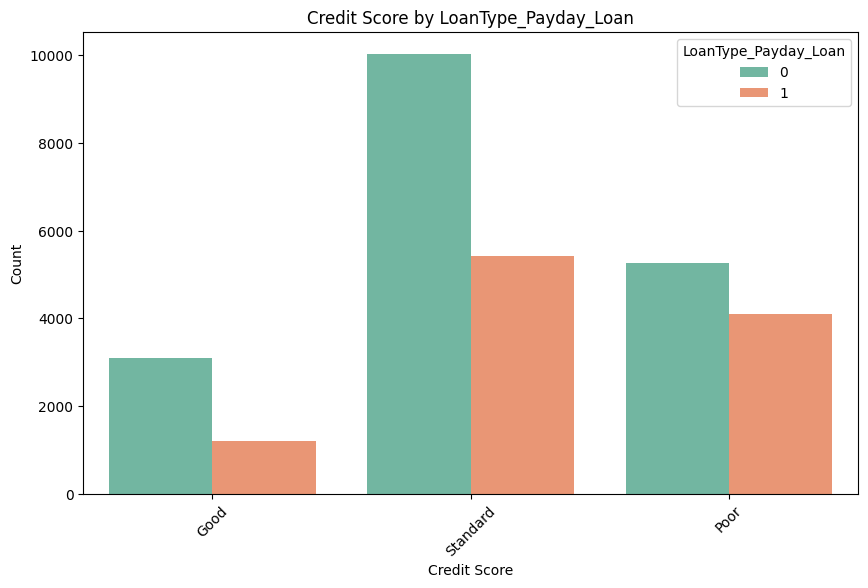

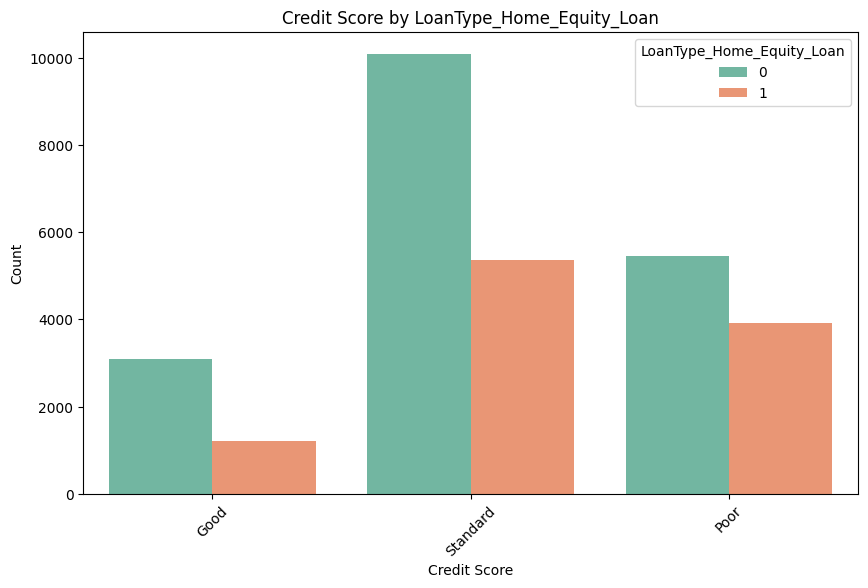

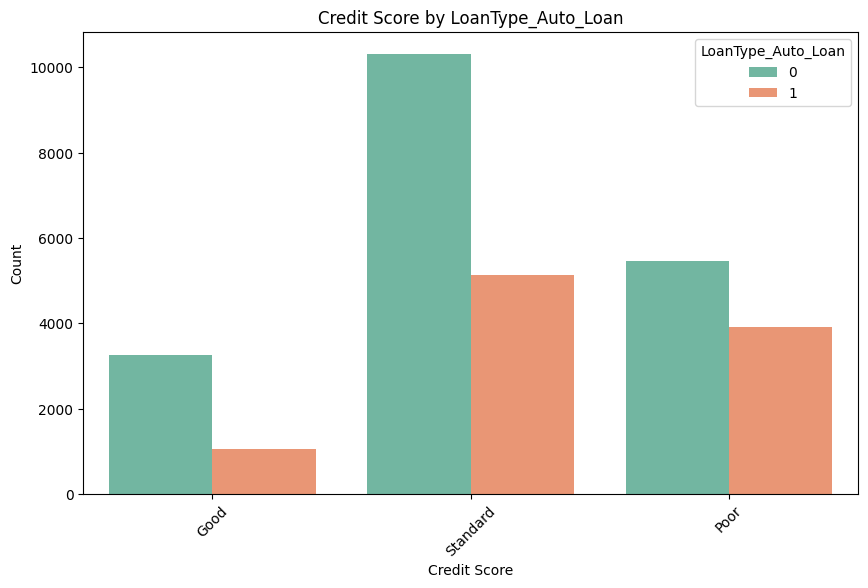

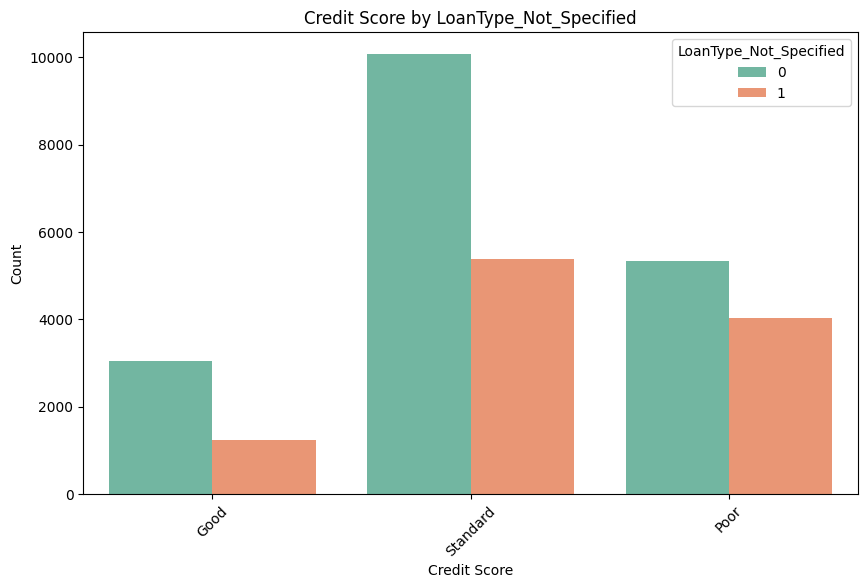

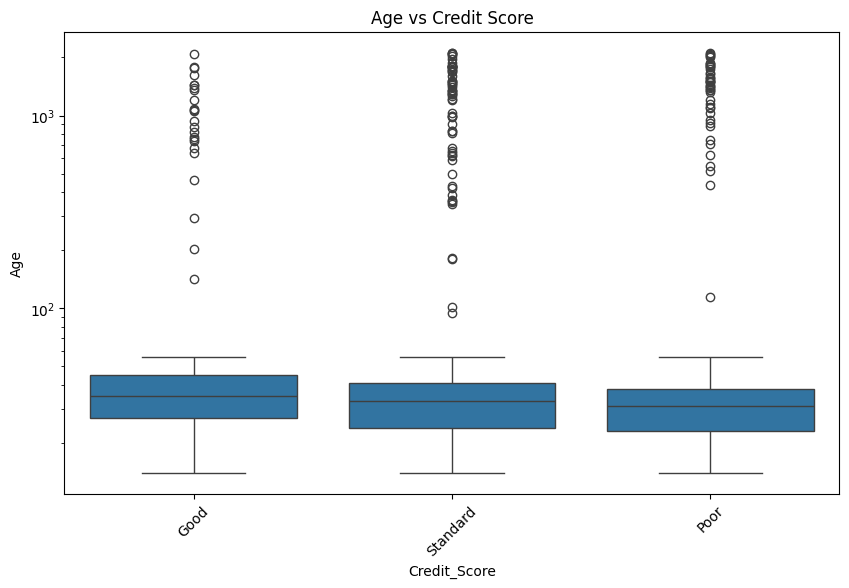

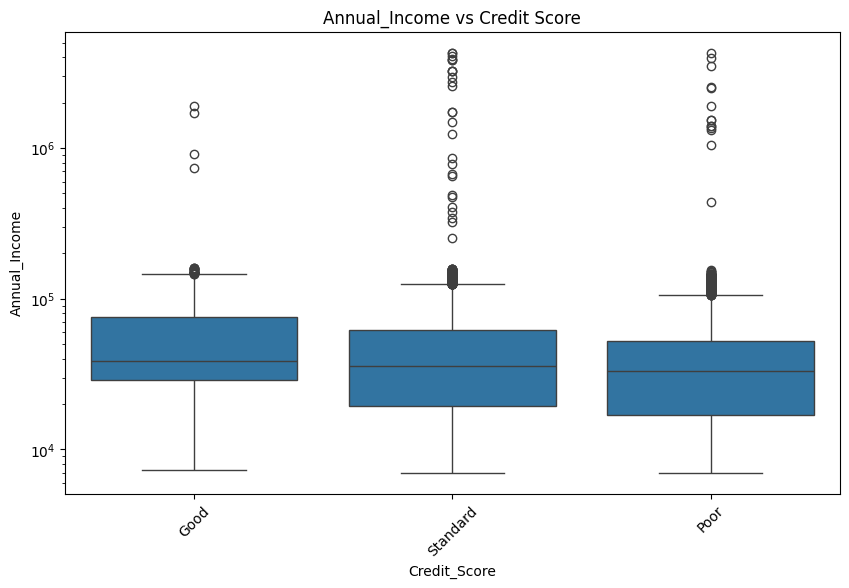

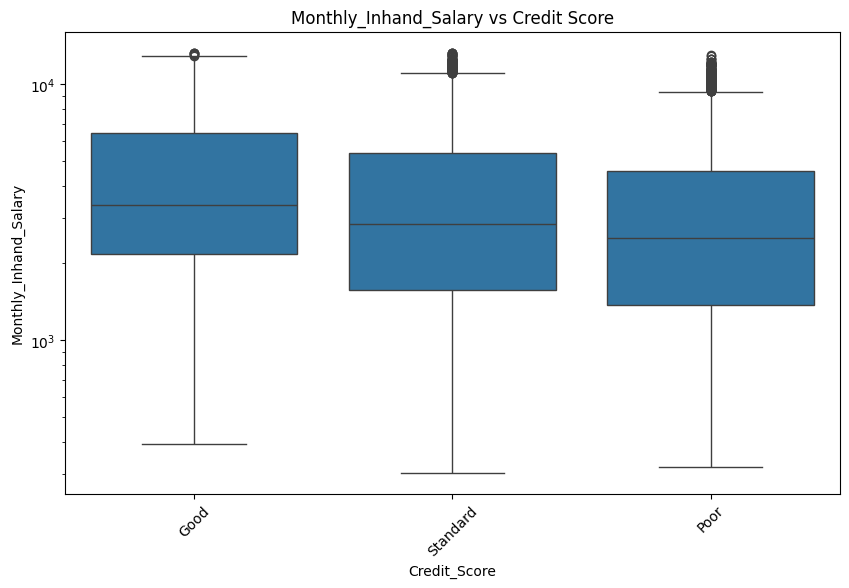

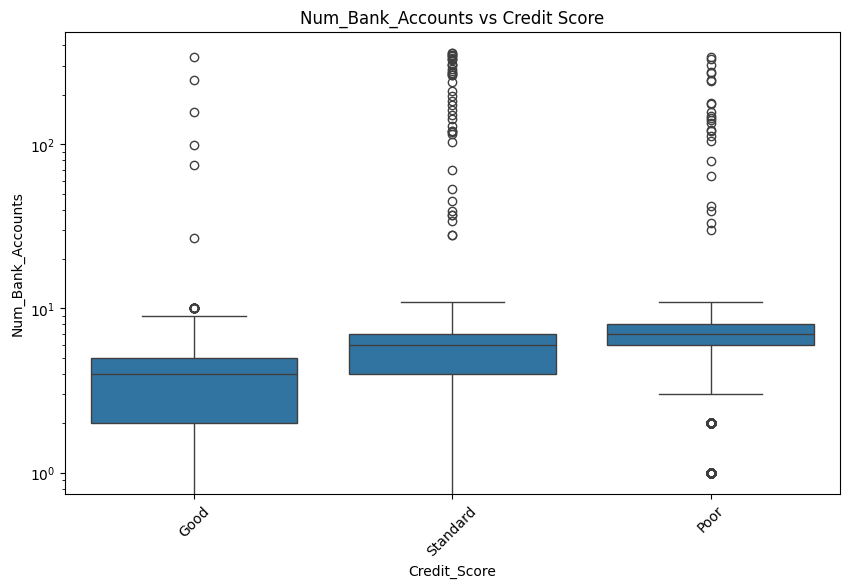

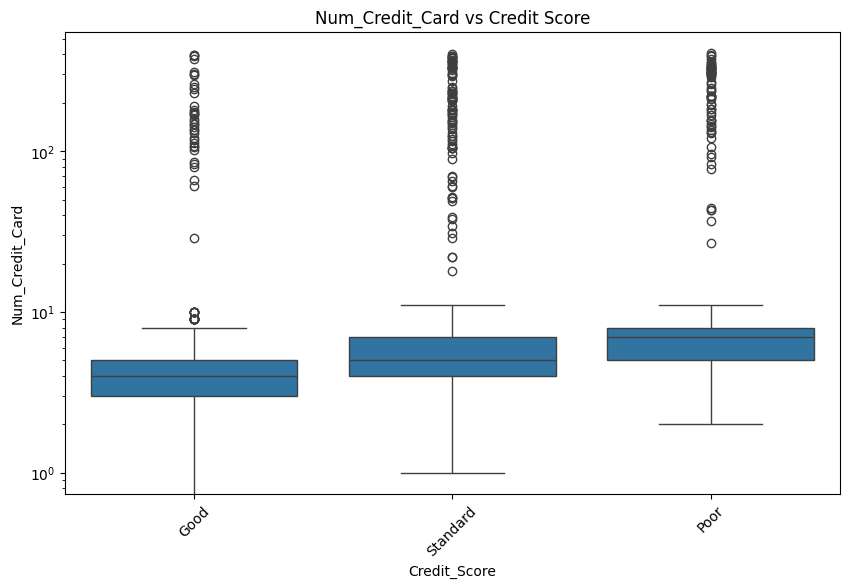

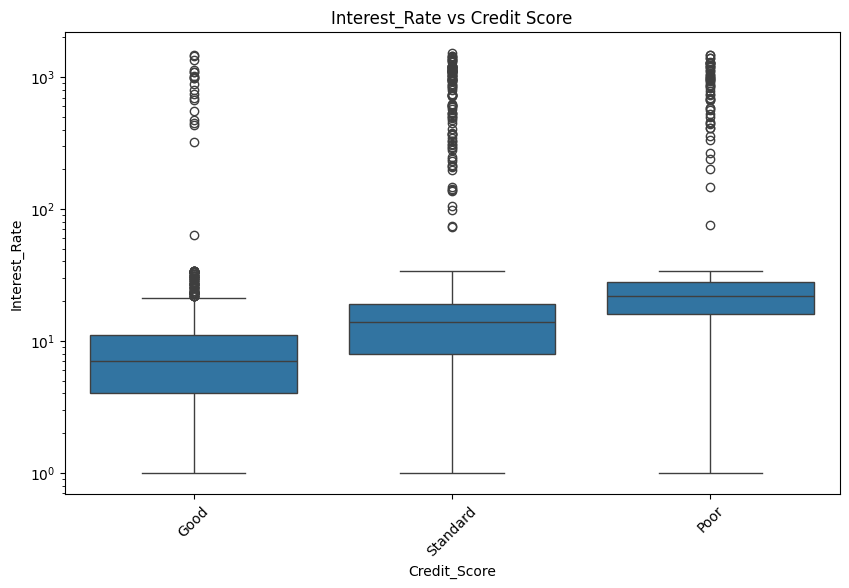

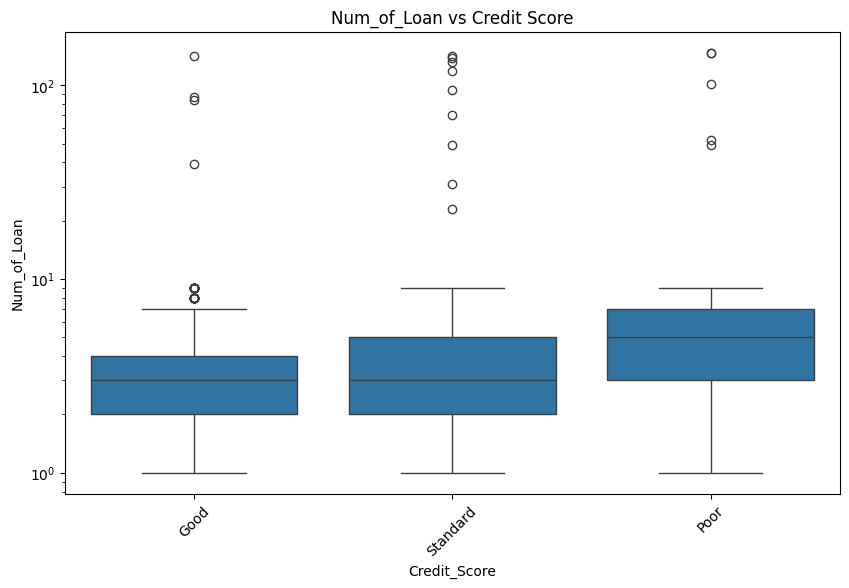

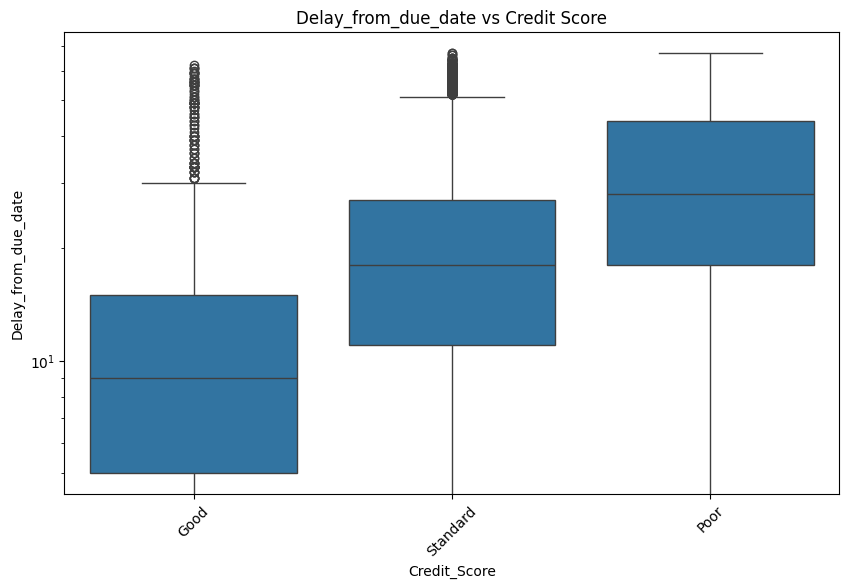

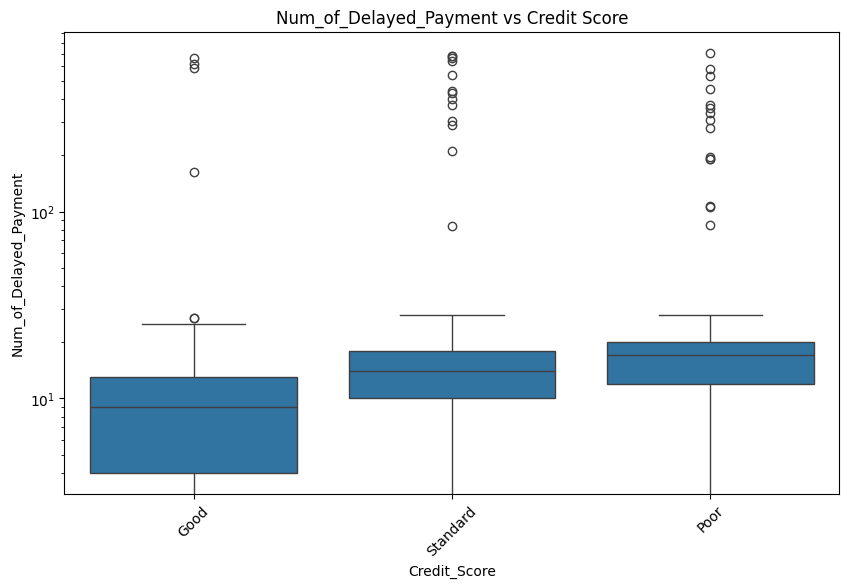

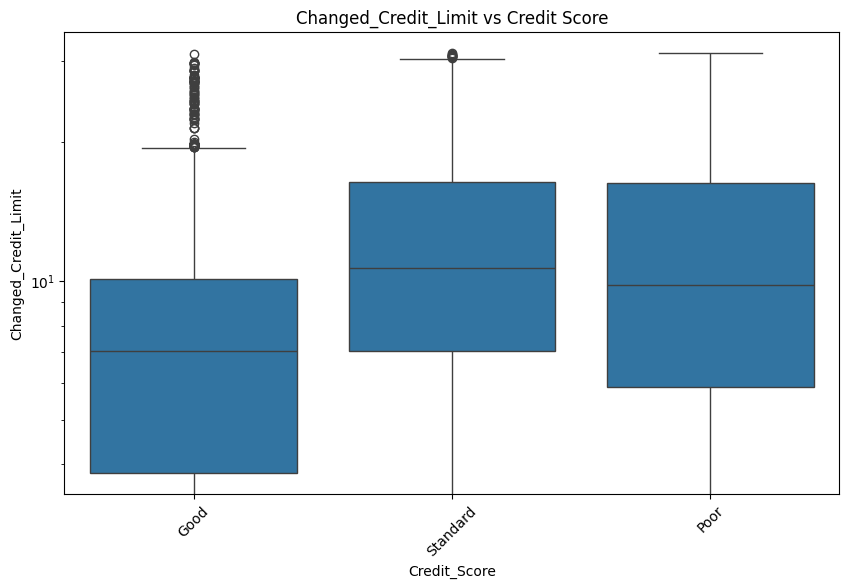

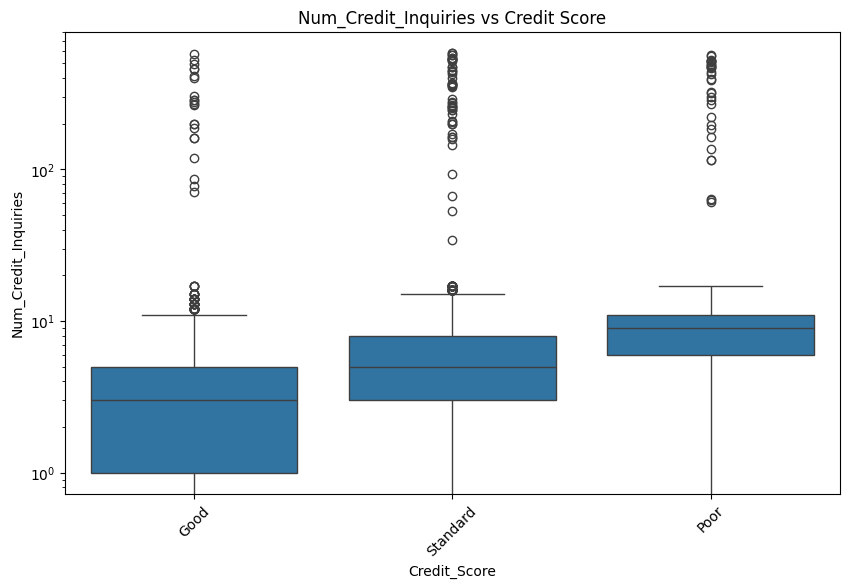

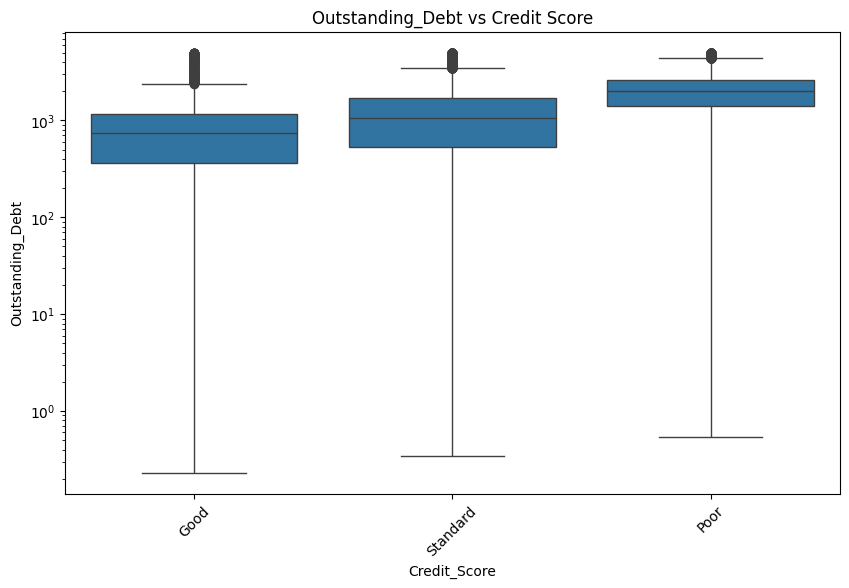

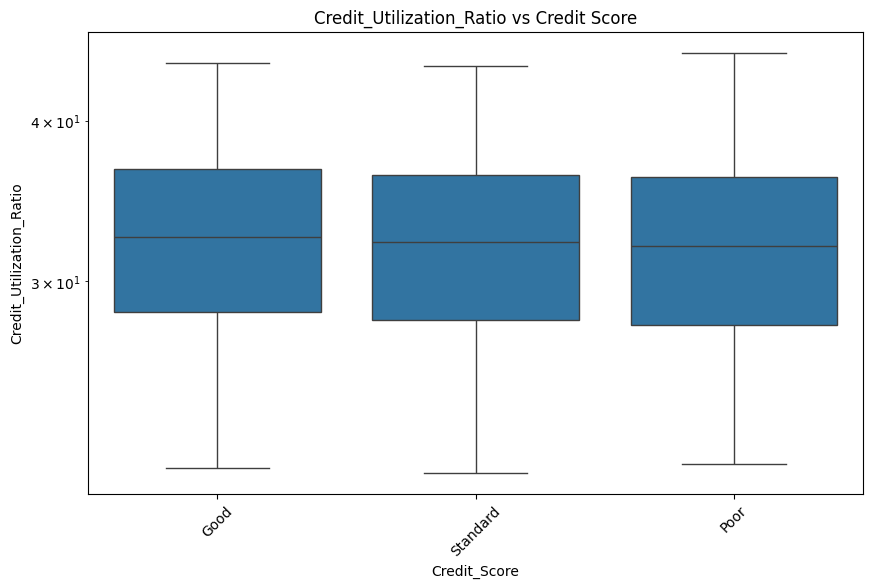

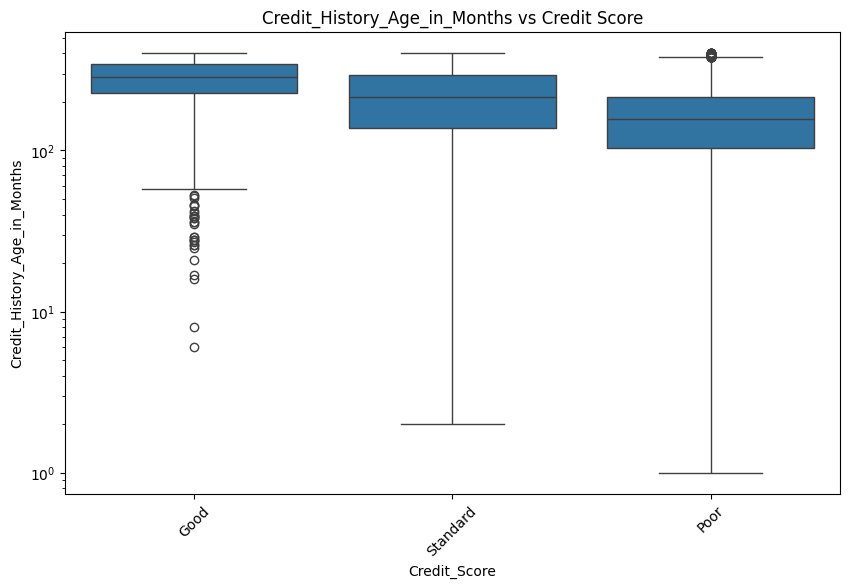

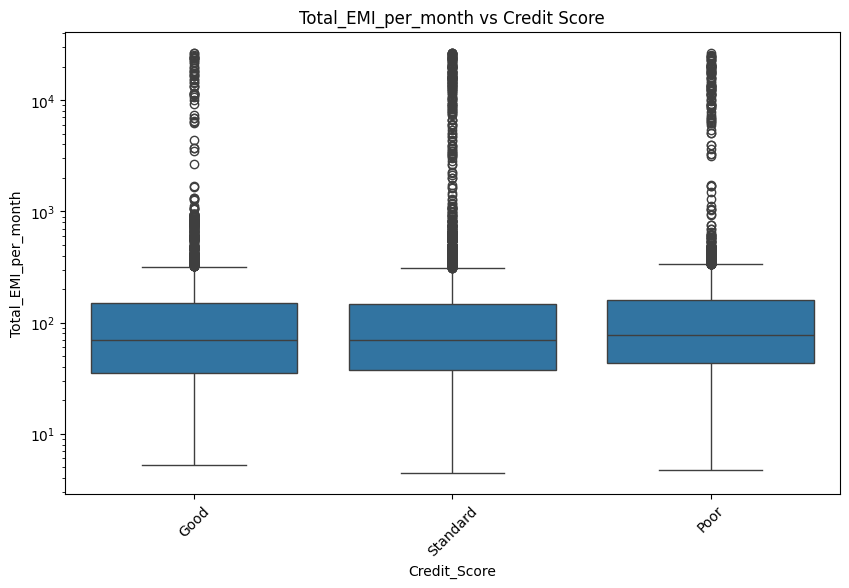

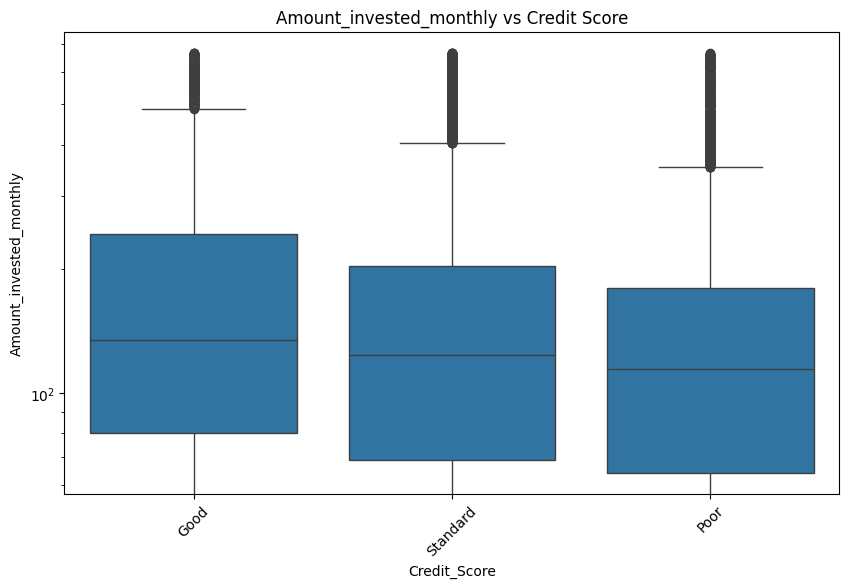

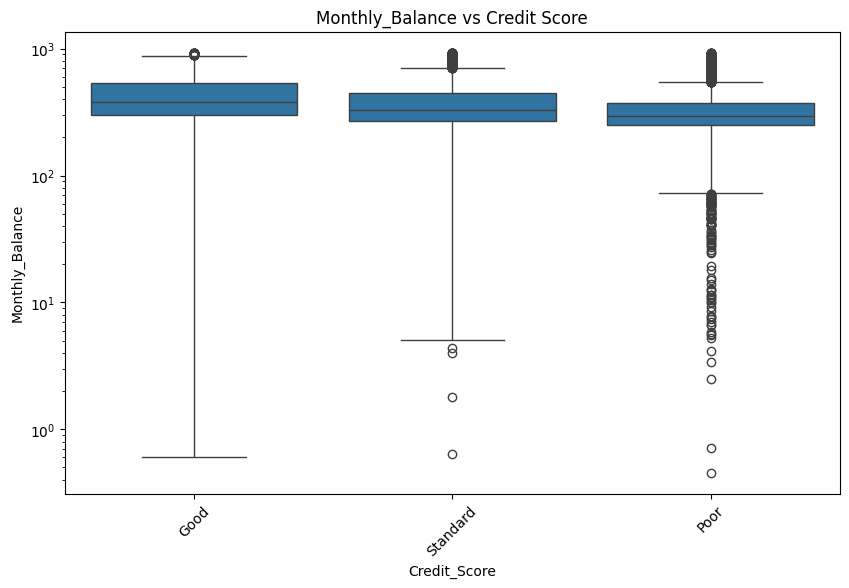

In [21]:
# Visualizing Categorical data
import matplotlib.pyplot as plt
import seaborn as sns

def plot_categorical_distribution(df, cat_column, target_column, title=None):
    plt.figure(figsize=(12, 8))
    sns.countplot(x=cat_column, hue=target_column, data=df, palette='Set2')
    plt.title(title if title else f'{target_column} by {cat_column}')
    plt.xticks(rotation=45)
    plt.legend(title=target_column)
    plt.show()

def plot_loan_type_vs_credit_score(df, loan_type_column, credit_score_column, title=None):
    plt.figure(figsize=(10, 6))
    sns.countplot(x=credit_score_column, hue=loan_type_column, data=df, palette='Set2')
    plt.title(title if title else f'Credit Score Distribution by {loan_type_column}')
    plt.xlabel('Credit Score')
    plt.ylabel('Count')
    plt.legend(title=loan_type_column)
    plt.xticks(rotation=45)
    plt.show()

unique_loan_types_columns =[col for col in filtered_df.columns if col.startswith('LoanType')]

plot_categorical_distribution(filtered_df, cat_column = 'Occupation',target_column='Credit_Score', title = 'Occupation distribution vs Credit Score')
plot_categorical_distribution(filtered_df, cat_column = 'Payment_Behaviour', target_column='Credit_Score', title = 'Payment Beheavior vs Credit Score')
plot_categorical_distribution(filtered_df, cat_column = 'Credit_Mix', target_column='Credit_Score', title = 'Credit_Mix vs Credit Score')
plot_categorical_distribution(filtered_df, cat_column = 'Payment_of_Min_Amount', target_column='Credit_Score', title = 'Credit_Mix vs Credit Score')
for loan_type in unique_loan_types_columns:
  plot_loan_type_vs_credit_score(df=filtered_df, loan_type_column=loan_type, credit_score_column='Credit_Score', title=f'Credit Score by {loan_type}')

continous_columns = ['Age','Annual_Income','Monthly_Inhand_Salary','Num_Bank_Accounts','Num_Credit_Card','Interest_Rate','Num_of_Loan','Delay_from_due_date','Num_of_Delayed_Payment','Changed_Credit_Limit','Num_Credit_Inquiries','Outstanding_Debt','Credit_Utilization_Ratio','Credit_History_Age_in_Months','Total_EMI_per_month','Amount_invested_monthly','Monthly_Balance']
#visualizing Numerical data
def plot_categorical_vs_continuous(df, cat_column, cont_column, title=None):
    plt.figure(figsize=(10, 6))
    sns.boxplot(x=cat_column, y=cont_column, data=df)
    plt.title(title if title else f'{cont_column} by {cat_column}')
    plt.xticks(rotation=45)
    plt.yscale('log')
    plt.show()

for column in continous_columns:
  plot_categorical_vs_continuous(df=filtered_df,cat_column='Credit_Score',cont_column=column,title = f'{column} vs Credit Score')

# Visualization
Matplot lib and sear horse are used to plot the data. Two functions are made to plot our data. One of them is to plot catageorical data vs categorical data asn produces a bar chart. The other one produces a histogram and plots continous vs categorical points. Visualizaing data during this phase helps determine if we need to drop any more features from our dataset. After analyzing all the independent variables against the target variable. There is enough variation between the classes of the target and the other features to include all of them in the model, so no further dropping of columns was necessary.

In [22]:
#Checking class distribution
print(filtered_df['Credit_Score'].value_counts())
print(filtered_df.head())

Standard    15448
Poor         9365
Good         4299
Name: Credit_Score, dtype: int64
     Age Occupation  Annual_Income  Monthly_Inhand_Salary  Num_Bank_Accounts  \
6   23.0  Scientist       19114.12            1824.843333                  3   
8   33.0    _______       34847.84            3037.986667                  2   
9   28.0    Teacher       34847.84            3037.986667                  2   
12  28.0    Teacher       34847.84            3037.986667                  2   
13  28.0    Teacher       34847.84            3037.986667                  2   

    Num_Credit_Card  Interest_Rate  Num_of_Loan  Delay_from_due_date  \
6                 4              3          4.0                    3   
8                 4              6          1.0                    3   
9                 4              6          1.0                    7   
12                4              6          1.0                    3   
13                4              6          1.0                    3   


In [23]:
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
#Changing non numeric columns to numerical data
#Encoding using one-hot encoder and label encoding based on data
nominal_columns = ["Occupation","Payment_Behaviour" ]
ordered_columns = ["Credit_Mix","Payment_of_Min_Amount","Credit_Score"]
#Initialize encoders
ohe = OneHotEncoder(sparse=False)
le = LabelEncoder()


for column in ordered_columns:
  filtered_df[column] = le.fit_transform(filtered_df[column])
for column in nominal_columns:
  encoded_data = ohe.fit_transform(filtered_df[[column]])
  encoded_df = pd.DataFrame(encoded_data, columns=[f"{column}_{category}" for category in ohe.categories_[0]])
  filtered_df.reset_index(drop=True, inplace=True)
  encoded_df.reset_index(drop=True, inplace=True)
  filtered_df = pd.concat([filtered_df, encoded_df], axis=1)
  filtered_df.drop(column, axis=1, inplace=True)


<ipython-input-23-a4665f2fe55c>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df[column] = le.fit_transform(filtered_df[column])
<ipython-input-23-a4665f2fe55c>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df[column] = le.fit_transform(filtered_df[column])
<ipython-input-23-a4665f2fe55c>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https

# Encoding
Machine Learning models can only handle numeric values. So our categorical data has to be converted or encoded. 2 methods for encoding were implemented. Label encoding was implemented for columns that have categorical data that could represent a weight. For example, Label encoding was used for the target column 'Credit_Score' because the order or weight of the categories - poor, standard, high - matters. The other method used is One Hot Encoding, which is used when categories are nominal, which means that the order or weight does not matter, or that.

In [24]:
#now that we know the count lets recategorize the data
#remove irrelevant entries from Payment behavior column
#print(outlier_df['Payment_Behaviour'].value_counts())
print(filtered_df.head())


    Age  Annual_Income  Monthly_Inhand_Salary  Num_Bank_Accounts  \
0  23.0       19114.12            1824.843333                  3   
1  33.0       34847.84            3037.986667                  2   
2  28.0       34847.84            3037.986667                  2   
3  28.0       34847.84            3037.986667                  2   
4  28.0       34847.84            3037.986667                  2   

   Num_Credit_Card  Interest_Rate  Num_of_Loan  Delay_from_due_date  \
0                4              3          4.0                    3   
1                4              6          1.0                    3   
2                4              6          1.0                    7   
3                4              6          1.0                    3   
4                4              6          1.0                    3   

   Num_of_Delayed_Payment  Changed_Credit_Limit  ...  Occupation_Scientist  \
0                    14.0                 11.27  ...                   1.0   
1       

# Assigning variables and train test split
All our features are assigned to an independent variable x, and our target is assigned to a variable y. An imputer is used to fill in any missing variables with he mean of the dataset in the case of our features.

In [25]:
#Assigning independent and dependent variables
#Remove NAN
#filtered_df = filtered_df.dropna()
#Alterantively  an imputer can be used to fill in the missing values
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(missing_values=np.nan, strategy='mean')

#Indepndent variables
x = filtered_df.drop('Credit_Score', axis=1)
imputer.fit(x)
x=pd.DataFrame(data=imputer.transform(x),columns=x.columns)
#Dependent variable: Last column
y = filtered_df["Credit_Score"]
print(x, "Independent Variables")
print(y, "Dependent Variable")

        Age  Annual_Income  Monthly_Inhand_Salary  Num_Bank_Accounts  \
0      23.0       19114.12            1824.843333                3.0   
1      33.0       34847.84            3037.986667                2.0   
2      28.0       34847.84            3037.986667                2.0   
3      28.0       34847.84            3037.986667                2.0   
4      28.0       34847.84            3037.986667                2.0   
...     ...            ...                    ...                ...   
29107  49.0       37188.10            3097.008333                1.0   
29108  49.0       37188.10            3097.008333                1.0   
29109  28.0       20002.88            1929.906667               10.0   
29110  28.0       20002.88            1929.906667               10.0   
29111  29.0       20002.88            1929.906667               10.0   

       Num_Credit_Card  Interest_Rate  Num_of_Loan  Delay_from_due_date  \
0                  4.0            3.0          4.0          

# Models
To be able to train our models, the independent and dependent variables are split into a 80:20 train, test split. Training datasets have to be larger than the test one so the model has enough data to train on. The ratio used is pretty standard for training and testing models. Three functions are made to test the model: train model, test model, and show model tests. The first function takes a model object and trains it on the training dataset that was made. Test simply tests and returns the result. Show tests calculates a confusion matrix from the reuslts of the test and displays.

In [26]:
#Splitting the dataset into a train and test split
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score , recall_score, precision_score,f1_score, roc_curve,auc,confusion_matrix, ConfusionMatrixDisplay


X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)
#Scale the dataset for better results
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

def train_model(model):
  model.fit(X_train_scaled,y_train)

def test_model(model):
  result = model.predict(X_test_scaled)
  print(result)
  return result

def show_model_tests(model):
  y_predict = test_model(model)
  print("Accuracy : ", accuracy_score(y_test, y_predict))
  print("Recall : ",recall_score(y_test, y_predict, average='weighted'))
  print("Precision: ", precision_score(y_test, y_predict, average='weighted'))
  print("F1-score: ", f1_score(y_test, y_predict, average='weighted'))
  model_confusion_matrix=confusion_matrix(y_test,y_predict)
  disp = ConfusionMatrixDisplay(confusion_matrix=model_confusion_matrix ,display_labels=["Poor", "Standard", "Good"])
  disp.plot(cmap=plt.cm.Greys)
  plt.xlabel("Predicted labels")
  plt.ylabel("Actual labels")
  plt.show()


# Random Forest
Random Forest is a machine learning model that uses multiple random decision trees to find the optimal tree to  make a prediction. Sklearn is used to create a model object and the model is passed into the functions that were previosuly made.

[1 1 2 ... 2 2 2]
Accuracy :  0.7630087583719732
Recall :  0.7630087583719732
Precision:  0.7633259481720336
F1-score:  0.7630769752143892


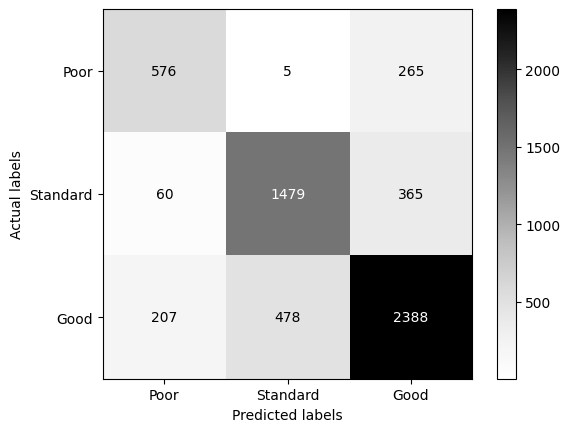

In [27]:
#Random Forest
from sklearn.ensemble import RandomForestClassifier
randomFClassifier = RandomForestClassifier(n_estimators=100, random_state=42)
train_model(randomFClassifier)
show_model_tests(randomFClassifier)

# Support Vector Machines
A machine learning model that seperates datasets be creating a multidimensional plane that acts as a divider. It creates a plane and then adjusts until it reaches the optimal solution based the hyperparamters provided

[2 1 2 ... 2 2 0]
Accuracy :  0.6831530139103554
Recall :  0.6831530139103554
Precision:  0.6923522863579161
F1-score:  0.6851316173647908


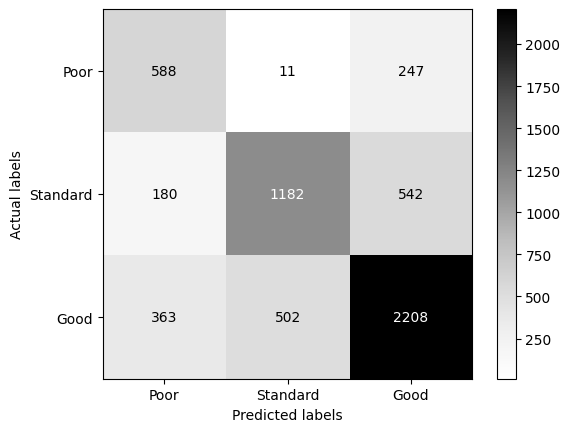

In [28]:
#Support Vector
from sklearn.svm import SVC
svmClassifier=SVC(probability=True)
train_model(svmClassifier)
show_model_tests(svmClassifier)

# Logistic Regression
Variation of the linear regression model that is used for classification. It finds a multidimensional line that represents the data. In the case of multiple classes it creates multiple binaries to be able to solve the problem

[2 1 2 ... 2 2 0]
Accuracy :  0.6276833247466942
Recall :  0.6276833247466942
Precision:  0.6271244505790919
F1-score:  0.6212388905875585


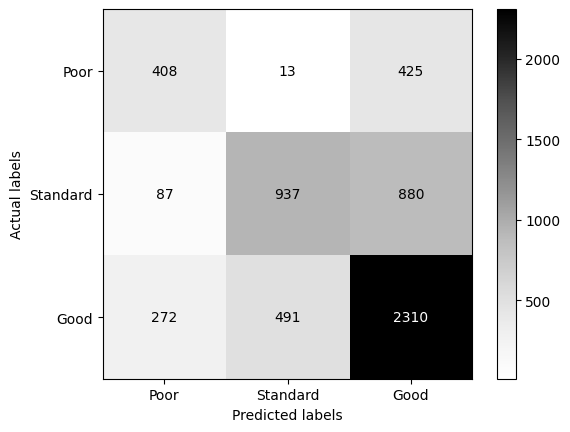

In [29]:
from sklearn.linear_model import LogisticRegression
lgclassifier=LogisticRegression()
train_model(lgclassifier)
show_model_tests(lgclassifier)

In [30]:
y_train[0:5]

11286    2
6334     1
24334    0
29049    1
20661    1
Name: Credit_Score, dtype: int64

# Neural Networks
Neural networks refer to a set of algorithms that are designed to mimic the human brain and how it classifies information. The cluster data through a number of algorithms and translate it into meaningful information based on the dataset that they were trained on.
To create an Artificial Neural Network model, the necessary model are imported from tensorflow. Then the hyperparameters are specified and the model is trained and tested on the test dataset. Scaling is necessary and encouraged for most models since it make the data more standarized and therefore more meanginful when fed into a model.

In [31]:
#Neural Network
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

def train_neural_network(X_train_scaled, y_trained_scaled):

    y_trained_scaled = to_categorical(y_trained_scaled, num_classes=3)

    # Define the model
    model = Sequential([
        Dense(64, activation='relu', input_shape=(X_train_scaled.shape[1],)),
        Dense(64, activation='relu'),
        Dense(3, activation='softmax')
    ])

    # Compile the model
    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    # Train the model
    model.fit(X_train_scaled, y_trained_scaled, epochs=10, batch_size=32, verbose=1)

    return model


ann = train_neural_network(X_train_scaled, y_train)


Epoch 1/10
728/728 [==============================] - 3s 3ms/step - loss: 0.7935 - accuracy: 0.6209
Epoch 2/10
728/728 [==============================] - 2s 3ms/step - loss: 0.7125 - accuracy: 0.6739
Epoch 3/10
728/728 [==============================] - 2s 3ms/step - loss: 0.6917 - accuracy: 0.6869
Epoch 4/10
728/728 [==============================] - 3s 4ms/step - loss: 0.6752 - accuracy: 0.6956
Epoch 5/10
728/728 [==============================] - 2s 3ms/step - loss: 0.6649 - accuracy: 0.7045
Epoch 6/10
728/728 [==============================] - 2s 3ms/step - loss: 0.6540 - accuracy: 0.7099
Epoch 7/10
728/728 [==============================] - 2s 3ms/step - loss: 0.6434 - accuracy: 0.7166
Epoch 8/10
728/728 [==============================] - 2s 3ms/step - loss: 0.6351 - accuracy: 0.7189
Epoch 9/10
728/728 [==============================] - 3s 4ms/step - loss: 0.6256 - accuracy: 0.7259
Epoch 10/10
728/728 [==============================] - 2s 3ms/step - loss: 0.6162 - accuracy: 0.7317

182/182 [==============================] - 0s 1ms/step
Accuracy :  0.6810922205048944
Recall :  0.6810922205048944
Precision:  0.6780568917635595
F1-score:  0.6782299664740218


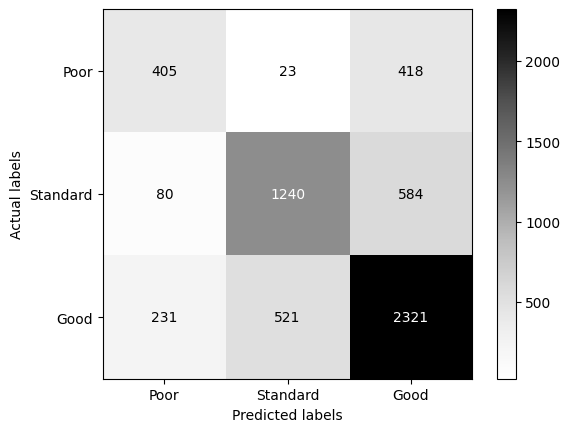

In [32]:
y_predict = ann.predict(X_test_scaled)
y_predict=tf.argmax(y_predict, axis = 1)
print("Accuracy : ", accuracy_score(y_test, y_predict))
print("Recall : ",recall_score(y_test, y_predict, average='weighted'))
print("Precision: ", precision_score(y_test, y_predict, average='weighted'))
print("F1-score: ", f1_score(y_test, y_predict, average='weighted'))
model_confusion_matrix=confusion_matrix(y_test,y_predict)
disp = ConfusionMatrixDisplay(confusion_matrix=model_confusion_matrix ,display_labels=["Poor", "Standard", "Good"])
disp.plot(cmap=plt.cm.Greys)
plt.xlabel("Predicted labels")
plt.ylabel("Actual labels")
plt.show()

# Fine Tuning
Most machine learning models require some level of fine tuning to be used effectively. This can be done through changing hyper parameters and using algorithms like Grid Search. Grid Search essentially evalutes various combinations of the hyper parameters given and then evaluates which combination is the most effective one. Grid Search was used for Logisitc Regression and Random forest and seen below. It yielded better results for random forest but did not imporve logisitc regression. That is most likely due to low number of repeats and splits used in the example so more iterations are needed to compute a more accurate model.

In [33]:
#Logistic Regression Fine Tuning
from sklearn.datasets import make_blobs
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import GridSearchCV
tunedlg=LogisticRegression(random_state=0)
penalty = ['l2']
c_values = [100, 10, 1.0, 0.1, 0.01]
grid = dict(penalty=penalty,C=c_values)
cv = RepeatedStratifiedKFold(n_splits=3, n_repeats=3, random_state=1)
grid = dict(penalty=penalty,C=c_values)
cv = RepeatedStratifiedKFold(n_splits=3, n_repeats=3, random_state=1)
grid_search = GridSearchCV(estimator=tunedlg, param_grid=grid, n_jobs=-1, cv=cv, scoring='accuracy',error_score=0)
grid_result = grid_search.fit(x, y)
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.537304 using {'C': 1.0, 'penalty': 'l2'}
0.536720 (0.006342) with: {'C': 100, 'penalty': 'l2'}
0.536594 (0.004899) with: {'C': 10, 'penalty': 'l2'}
0.537304 (0.002749) with: {'C': 1.0, 'penalty': 'l2'}
0.537155 (0.006548) with: {'C': 0.1, 'penalty': 'l2'}
0.536205 (0.003586) with: {'C': 0.01, 'penalty': 'l2'}


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [34]:
#Random Forest fine tuning
param_grid = {
    'n_estimators': [100, 200, 300],  # Number of trees in the forest
    'max_depth': [ 10, 20, 30],  # Maximum depth of the tree
    'min_samples_split': [2, 5, 10],  # Minimum number of samples required to split an internal node
    'min_samples_leaf': [1, 2, 4],  # Minimum number of samples required to be at a leaf node
}
# Initialize the Random Forest classifier
rf = RandomForestClassifier(random_state=42)

# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=2, verbose=2, n_jobs=-1)

# Fit GridSearchCV
grid_search.fit(X_train_scaled, y_train)
print("Best parameters:", grid_search.best_params_)
print("Best score:", grid_search.best_score_)
best_model = grid_search.best_estimator_

Fitting 2 folds for each of 81 candidates, totalling 162 fits
Best parameters: {'max_depth': 30, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}
Best score: 0.7471339335745331
